# Dietary Restriction AI

### Import Packages

In [1]:
pip install langchain_community pandas pyspark sentence_transformers tokenizers faiss-cpu textstat nltk fireducks matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from langchain_community.llms import Ollama
import os
import json
import fireducks.pandas as pd 
import numpy as np
import tempfile 

from sentence_transformers import SentenceTransformer, util
import faiss
import ollama

import os
import shutil

import re
from pyspark.sql.types import StringType, FloatType, MapType
import nltk
import textstat

import matplotlib.pyplot as plt
import seaborn as sns

### Initialize a Spark Session

### Data Ingestion
In order to be compatible with LLM that we will be creating, the data needs to be processed to be in an efficient retrieval format and stored in a searchable index. 

##### Recipe Data
Our recipe data is sourced from web-scraped data containing

In [3]:
all_files = os.listdir("./")
recipe_files = [file for file in all_files if "recipes_raw_nosource" in file]

df_list = []

for file_name in recipe_files: 
    temp_path = os.path.join(tempfile.gettempdir(), file_name)
    
    with open(file_name, "r", encoding="utf-8") as file:
        data = json.load(file)

    file_df = pd.DataFrame.from_dict(data, orient="index")
    df_list.append(file_df)  # Collect DataFrame
    
# Concatenate all dataframes
recipes_df = pd.concat(df_list)

# select only title, ingredient, instructions columns
recipes_df = recipes_df[['title', 'ingredients', 'instructions']]

# # repartition the dataframe 
# recipes_df = spark.createDataFrame(recipes_df)
# recipes_df = recipes_df.repartition(100)

recipes_df

,title,ingredients,instructions
p3pKOD6jIHEcjf20CCXohP8uqkG5dGi,Grammie Hamblet's Deviled Crab,"[1/2 cup celery, finely chopped, 1 small green...",Toss ingredients lightly and spoon into a butt...
S7aeOIrsrgT0jLP32jKGg4j.o9zi2DO,Infineon Raceway Baked Beans,"[2 pounds skirt steak, cut into 1/2-inch dice,...",Watch how to make this recipe.\nSprinkle the s...
o9MItV9txfoPsUQ4v8b0vh1.VdjwfsK,Southwestern Black Bean Dip,"[1 1/2 cups dried black beans, picked over and...","In a large saucepan, let the beans soak in eno..."
5l1yTSYFifF/M2dfbD6DX28WWQpLWNK,Sour Cream Noodle Bake,"[1 1/4 pounds ground chuck, One 15-ounce can t...",Watch how to make this recipe.\nPreheat the ov...
kRBQSWtqYWqtkb34FGeenBSbC32gIdO,Sushi Renovation,"[1 cup rice, brown, medium-grain, cooked, 1/2-...",Special equipment: sushi mat\nCook the brown r...
...,...,...,...
gehEOcDPtU3SmNSXrwWwWD4ulPpUdMO,Thai-Indian Veggie Soup,"[2 teaspoons olive oil ADVERTISEMENT, 1/4 cup ...",Heat oil in a large pot over medium heat. Add ...
VRAsyF.1xMBYqAVKX1biyIORH6N6qzy,Coconut Milk-Free Panang Curry Chicken,"[2 cups light cream ADVERTISEMENT, 1/4 teaspoo...",Heat cream and coconut extract in a skillet or...
Lf8/u.0k2029QMSQFrHS4gRsvKOQFUG,Cooked Cold Salad,"[3 tablespoons bacon grease ADVERTISEMENT, 2 c...",Heat bacon grease in a skillet over medium-hig...
ay.AqX/9ysBtWHcnHoDeGAyJ5Orla8e,Easy Eggnog Creme Brulee,"[4 egg yolks ADVERTISEMENT, 1 tablespoon white...",Preheat oven to 350 degrees F (175 degrees C)....


##### Cooking Literature Data

The cooking literature data was pre-processed from PDF text files into a usable format in another notebook.

### Data Chunking
##### Recipes Data
The data was chunked into recipe-level chunks, since the recipes will then be able toi be referenced individually when needed. Since this use case is about modifying recipes in their entirety, we want the model to be able to reference the recipes in their entirety during its retrieval process. 

In [4]:
# combine title, ingredients, and instructions into a single string column
recipes_df["chunk_text"] = recipes_df[["title", "ingredients", "instructions"]].apply(
    lambda row: "\n".join(str(x) for x in row), axis=1
)

# select only the chunk_text column and rename it to recipe_text
recipes_df = recipes_df[["chunk_text"]].rename(columns={"chunk_text": "recipe_text"})

recipes_df.head()


,recipe_text
p3pKOD6jIHEcjf20CCXohP8uqkG5dGi,Grammie Hamblet's Deviled Crab\n['1/2 cup cele...
S7aeOIrsrgT0jLP32jKGg4j.o9zi2DO,Infineon Raceway Baked Beans\n['2 pounds skirt...
o9MItV9txfoPsUQ4v8b0vh1.VdjwfsK,Southwestern Black Bean Dip\n['1 1/2 cups drie...
5l1yTSYFifF/M2dfbD6DX28WWQpLWNK,Sour Cream Noodle Bake\n['1 1/4 pounds ground ...
kRBQSWtqYWqtkb34FGeenBSbC32gIdO,"Sushi Renovation\n['1 cup rice, brown, medium-..."


### Generate Embeddings

In [5]:
# Load chunked JSON data
with open("chunked_data.json", "r", encoding="utf-8") as f:
    chunked_data = json.load(f)

# load model and generate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = np.array([embedding_model.encode(chunk["body"]) for chunk in chunked_data], dtype=np.float32)

# Store embeddings in chunked JSON
for i, chunk in enumerate(chunked_data):
    chunk["embedding"] = embeddings[i].tolist()
    
# Create and save FAISS index
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings)

### Model Ingestion

##### Prompt Engineering
The prompt inputted by the user should only need to contain the necessary recipe that the user wants to modify. The following prompt engineering code adds additional, consistent language that does the following: 
- Specifies that the user wants to modify the recipe, retaining the original intention
- Provides the dietary framework to stick to, in this case the high-protein low-carb diet. In another phase of development, this could be changed to xspecify a diet of choice
- Requests a list of macronutrients based on the data

##### RAG Component

In [6]:
def retrieve_relevant_chunks(query, k=5):
    """Retrieve top-k most relevant chunks using FAISS."""
    query_embedding = embedding_model.encode(query).reshape(1, -1)  # Convert query to embedding
    distances, indices = index.search(query_embedding, k)  # Retrieve top-k chunks

    return [chunked_data[i] for i in indices[0]]  # Get original text chunks

def query_ollama_with_context(query):
    """Retrieve relevant context and query Ollama 3.2."""
    retrieved_chunks = retrieve_relevant_chunks(query)
    context = "\n".join([chunk["body"] for chunk in retrieved_chunks])  # Combine relevant chunks

    # Formulate prompt for LLaMA
    prompt = f"Context:\n{context}\n\nQuery: {query}\nAnswer:"

    # Query Ollama
    response = ollama.chat(model="llama3.2", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"]

In [7]:
# if __name__ == "__main__":
#     query = input("Enter your recipe: ")
#     query += " Modify this recipe so that it is more suited for a high-protein, low carb diet. Provide a list of macronutrients as a part of the analysis."
#     answer = query_ollama_with_context(query)
#     print("\nOllama's Answer:", answer)

In [8]:
# Sample 10% of the DataFrame
sampled_recipes = recipes_df.sample(frac=0.1, replace=False)

results = []

# Loop through the sampled recipes
for line_num, (idx, recipe_text) in enumerate(sampled_recipes["recipe_text"].items()):
    raw_query = recipe_text  # Use the actual recipe text
    
    query = f"""{raw_query}
    
    Determine whether the recipe is meant to be eaten as a meal or snack (e.g., entrée, side dish, appetizer, etc.). 
    If it is a drink, condiment, sauce, dressing, spice blend, marinade, or ingredient prep, reply with:  
    "This is not a standalone dish and does not need modification.", briefly explain why and stop.
    
    If the dish is a meal or a snack, revise it with healthy choices to better support a high-protein, low-carbohydrate diet. 
    Avoid high fat ingredients and low fat cooking methods where possible. 
    Make changes to ingredients and preparation steps while preserving the recipe’s original concept and flavor.
    
    Use this general nutrition target:
    - 45-50g protein  
    - 14-20g fat  
    - 20-30g carbs  
    (Total: 450-550 calories; approximate ratio 6:2:3 in grams)
    Calcualte the nutritional value and if the recipe does not meet the above nutritional target, revise it again until it does.
    ---
    Return only the final, improved version of the recipe, including:
    - A recipe title
    - A natural explanation of the key changes
    - A revised ingredient list and instructions
    - An informal summary of the macronutrient profile (in grams and approximate calories) with this format: 
        Protein: #.#g
        Fats: #.#g
        Carbohydrates: #.#g
        Total Calories: ###
    Write as if sharing the final version of a recipe in a friendly, informative tone.
    """

    try:
        answer = query_ollama_with_context(query)
        results.append({
            "original_recipe": raw_query,
            "modified_response": answer
        })
        print(f"Completed line {line_num}")
    except Exception as e:
        results.append({
            "original_recipe": raw_query,
            "modified_response": f"Error: {e}"
        })



Completed line 0
Completed line 1
Completed line 2
Completed line 3
Completed line 4
Completed line 5
Completed line 6
Completed line 7
Completed line 8
Completed line 9
Completed line 10
Completed line 11
Completed line 12
Completed line 13
Completed line 14
Completed line 15
Completed line 16
Completed line 17
Completed line 18
Completed line 19
Completed line 20
Completed line 21
Completed line 22
Completed line 23
Completed line 24
Completed line 25
Completed line 26
Completed line 27
Completed line 28
Completed line 29
Completed line 30
Completed line 31
Completed line 32
Completed line 33
Completed line 34
Completed line 35
Completed line 36
Completed line 37
Completed line 38
Completed line 39
Completed line 40
Completed line 41
Completed line 42
Completed line 43
Completed line 44
Completed line 45
Completed line 46
Completed line 47
Completed line 48
Completed line 49
Completed line 50
Completed line 51
Completed line 52
Completed line 53
Completed line 54
Completed line 55
Co

KeyboardInterrupt: 

In [9]:
results_df = pd.DataFrame(results)
results_df

,original_recipe,modified_response
0,Hot Cross Buns\n['2 cups whole milk' '1/2 cup ...,"Hot Cross Buns (High-Protein, Low-Carb Version..."
1,Orange Turkey Brine\n['1 (12 fluid ounce) can ...,**Orange-Glazed Turkey Breast with Crispy Skin...
2,Gluten-Free Strawberry Shortcake\n['2/3 cup br...,Gluten-Free Strawberry Shortcake Revamped\n\nT...
3,Chicken and Spring Green Gratin \n['1 pound da...,**Healthier Chicken and Spring Green Gratin**\...
4,"Grilled Turkey, Bacon, Radicchio, and Blue Che...","**Grilled Turkey, Bacon-Free Radicchio, and Go..."
...,...,...
3945,Chunky Red Chili \n['3 tablespoons olive oil' ...,**Improved Chunky Red Chili Recipe**\n\nAfter ...
3946,Cranberry Eggnog Tart \n['1 1/4 cups all-purpo...,Cranberry Eggnog Tart (Revised)\n\nTo make thi...
3947,"The Elvis\n['2 tablespoons butter, softened' '...",**Elvis's Peanut Butter Banana Sandwich Reviva...
3948,Chocolate-Peanut Butter Swirl Smoothie\n['2 ou...,**Revised Recipe:** Chocolate-Peanut Butter Sw...


In [10]:
# save file as an intermediatry dataframe
results_df.to_csv("modified_recipes.csv", index=False, encoding="utf-8")

In [11]:
    # ### Substitution Guidelines:
    # - Prioritize lean protein sources.
    # - Avoid cream, butter, full-fat cheese, fatty meats, or excessive oils.
    # - Use low-fat cooking methods (grilling, baking, steaming).
    # - Favor vegetables and legumes over starchy carbs.
    # - Use cooking spray or broth instead of oil where possible.
    # - **Only make substitutions that are likely to still taste good and preserve the appeal of the dish.** Avoid swaps that would make 
    # the texture or flavor unpleasant.

    # Avoid high-fat ingredients such as:
    # - oils (even olive oil or coconut oil)
    # - cream, butter, or cheese (unless low-fat versions are used in moderation)
    # - fatty meats (like bacon, sausage, ground beef)
    # - full-fat dairy
    # - avocados, nuts, and seeds (limit to small quantities only if essential)
    
    # Use the following **low-fat flavor and texture enhancers** instead:
    # - vinegar, lemon juice, mustard, garlic, spices
    # - vegetable purées (e.g., carrot, cauliflower, zucchini)
    # - low-fat dairy alternatives (e.g., non-fat Greek yogurt, fat-free cottage cheese)
    # - broth-based sauces instead of cream sauces

### Recipe Evaluator

In [12]:
def extract_macronutrients(recipe_text):
    # Define a regular expression pattern to search for protein, fat, and carbs
    protein_pattern = r"Protein:\s*(\d+(?:\.\d+)?)\s*g"
    fat_pattern     = r"Fats:\s*(\d+(?:\.\d+)?)\s*g"
    carbs_pattern   = r"Carbohydrates:\s*(\d+(?:\.\d+)?)\s*g"

    
    # Search the text for the respective macronutrients
    protein = re.search(protein_pattern, recipe_text)
    fat = re.search(fat_pattern, recipe_text)
    carbs = re.search(carbs_pattern, recipe_text)
    
    # Extract the values if found
    protein_value = float(protein.group(1)) if protein else None
    fat_value = float(fat.group(1)) if fat else None
    carbs_value = float(carbs.group(1)) if carbs else None
    
    # Return the extracted values
    return {
        "P": protein_value,
        "F": fat_value,
        "C": carbs_value
    }

In [13]:
def evaluate_recipe(protein_g, fat_g, carb_g):
    # Caloric values per gram
    PROTEIN_CAL = 4
    CARB_CAL = 4
    FAT_CAL = 9

    if protein_g is not None and fat_g is not None and carb_g is not None:
        # Calculate total calories
        total_calories = (protein_g * PROTEIN_CAL) + (fat_g * FAT_CAL) + (carb_g * CARB_CAL)
        
        if total_calories == 0:
            return "Invalid recipe: Total calories cannot be zero."
        
        # Calculate macronutrient percentage
        protein_pct = (protein_g * PROTEIN_CAL / total_calories) * 100
        fat_pct = (fat_g * FAT_CAL / total_calories) * 100
        carb_pct = (carb_g * CARB_CAL / total_calories) * 100
        
        # Define healthy ranges
        protein_range = (30, 50)
        fat_range = (20, 40)
        carb_range = (10, 30)
        
        # Check if recipe meets healthy criteria
        if (protein_range[0] <= protein_pct <= protein_range[1] and
            fat_range[0] <= fat_pct <= fat_range[1] and
            carb_range[0] <= carb_pct <= carb_range[1]):
            return "Meets Criteria"
        else:
            return "Does Not Meet Criteria"
    else: 
        return None
        
# Example usage
recipe_result = evaluate_recipe(protein_g=35.2, fat_g=14.2, carb_g=12.8)
print(recipe_result)

Meets Criteria


In [14]:
# Assume you already have results_df as a pandas DataFrame
# And the functions extract_macronutrients() and evaluate_recipe() are defined

# Step 1: Extract macros
results_df["macros"] = results_df["modified_response"].apply(extract_macronutrients)

# Step 2: Evaluate dietary compliance
results_df["dietary_compliance"] = results_df["macros"].apply(
    lambda m: evaluate_recipe(m.get("P", 0), m.get("F", 0), m.get("C", 0))
)

# Step 3: Add individual macro columns
results_df["protein"] = results_df["macros"].apply(lambda m: m.get("P", 0))
results_df["fat"] = results_df["macros"].apply(lambda m: m.get("F", 0))
results_df["carbohydrates"] = results_df["macros"].apply(lambda m: m.get("C", 0))

# Step 4: Compute calorie breakdown
results_df["protein_calories"] = results_df["protein"] * 4
results_df["fat_calories"] = results_df["fat"] * 9
results_df["carb_calories"] = results_df["carbohydrates"] * 4
results_df["total_calories"] = results_df["protein_calories"] + results_df["fat_calories"] + results_df["carb_calories"]

# Step 5: Compute calorie percentages (with safe division)
results_df["percent_protein"] = results_df["protein_calories"] / results_df["total_calories"].replace(0, pd.NA)
results_df["percent_fat"] = results_df["fat_calories"] / results_df["total_calories"].replace(0, pd.NA)
results_df["percent_carb"] = results_df["carb_calories"] / results_df["total_calories"].replace(0, pd.NA)


In [15]:
results_df

,original_recipe,modified_response,macros,dietary_compliance,protein,fat,carbohydrates,protein_calories,fat_calories,carb_calories,total_calories,percent_protein,percent_fat,percent_carb
0,Hot Cross Buns\n['2 cups whole milk' '1/2 cup ...,"Hot Cross Buns (High-Protein, Low-Carb Version...","{'C': 25.0, 'F': 15.0, 'P': 35.0}",Meets Criteria,35.0,15.0,25.0,140.0,135.0,100.0,375.0,0.373333,0.360000,0.266667
1,Orange Turkey Brine\n['1 (12 fluid ounce) can ...,**Orange-Glazed Turkey Breast with Crispy Skin...,"{'C': 20.0, 'F': 10.0, 'P': 45.0}",Does Not Meet Criteria,45.0,10.0,20.0,180.0,90.0,80.0,350.0,0.514286,0.257143,0.228571
2,Gluten-Free Strawberry Shortcake\n['2/3 cup br...,Gluten-Free Strawberry Shortcake Revamped\n\nT...,"{'C': 19.0, 'F': 16.0, 'P': 42.0}",Meets Criteria,42.0,16.0,19.0,168.0,144.0,76.0,388.0,0.432990,0.371134,0.195876
3,Chicken and Spring Green Gratin \n['1 pound da...,**Healthier Chicken and Spring Green Gratin**\...,"{'C': 20.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,20.0,188.0,108.0,80.0,376.0,0.500000,0.287234,0.212766
4,"Grilled Turkey, Bacon, Radicchio, and Blue Che...","**Grilled Turkey, Bacon-Free Radicchio, and Go...","{'C': 20.0, 'F': 10.0, 'P': 52.0}",Does Not Meet Criteria,52.0,10.0,20.0,208.0,90.0,80.0,378.0,0.550265,0.238095,0.211640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,Chunky Red Chili \n['3 tablespoons olive oil' ...,**Improved Chunky Red Chili Recipe**\n\nAfter ...,"{'C': 22.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,22.0,188.0,108.0,88.0,384.0,0.489583,0.281250,0.229167
3946,Cranberry Eggnog Tart \n['1 1/4 cups all-purpo...,Cranberry Eggnog Tart (Revised)\n\nTo make thi...,"{'C': 15.0, 'F': 10.0, 'P': 47.0}",Does Not Meet Criteria,47.0,10.0,15.0,188.0,90.0,60.0,338.0,0.556213,0.266272,0.177515
3947,"The Elvis\n['2 tablespoons butter, softened' '...",**Elvis's Peanut Butter Banana Sandwich Reviva...,"{'C': 22.0, 'F': 12.0, 'P': 35.0}",Meets Criteria,35.0,12.0,22.0,140.0,108.0,88.0,336.0,0.416667,0.321429,0.261905
3948,Chocolate-Peanut Butter Swirl Smoothie\n['2 ou...,**Revised Recipe:** Chocolate-Peanut Butter Sw...,"{'C': 20.0, 'F': 13.0, 'P': 37.0}",Meets Criteria,37.0,13.0,20.0,148.0,117.0,80.0,345.0,0.428986,0.339130,0.231884


In [16]:
results_df.describe()

,protein,fat,carbohydrates,protein_calories,fat_calories,carb_calories,total_calories,percent_protein,percent_fat,percent_carb
count,3896.000000,3898.000000,3898.000000,3896.000000,3898.000000,3898.000000,3896.000000,3896.000000,3896.000000,3896.000000
mean,40.376181,13.302258,17.669959,161.504723,119.720318,70.679836,351.921509,0.453311,0.341919,0.204770
std,10.204834,3.123093,4.900160,40.819335,28.107834,19.600639,62.985148,0.077342,0.072745,0.065613
min,0.500000,0.000000,2.000000,2.000000,0.000000,8.000000,32.000000,0.038610,0.000000,0.027778
25%,37.000000,12.000000,15.000000,148.000000,108.000000,60.000000,324.000000,0.424242,0.300000,0.169447
50%,45.000000,14.000000,20.000000,180.000000,126.000000,80.000000,370.000000,0.466321,0.327003,0.207254
75%,47.000000,15.000000,22.000000,188.000000,135.000000,88.000000,394.000000,0.494505,0.371901,0.229167
max,65.000000,26.000000,31.000000,260.000000,234.000000,124.000000,498.000000,0.774194,0.837775,0.926641


In [17]:
for num, answer in enumerate(results_df["modified_response"][:10]): 
    print(f"--------------------------------------{num}---------------------------------------------")
    print(answer)

--------------------------------------0---------------------------------------------
Hot Cross Buns (High-Protein, Low-Carb Version)

In this revised recipe, I've made several changes to create a delicious and healthier Hot Cross Bun, perfect for a high-protein, low-carb diet. The original recipe was modified to replace traditional sugar with natural sweeteners, reduce the amount of fat, and incorporate more protein-rich ingredients.

**Ingredients:**

* 2 cups whole milk
* 1/4 cup canola oil (reduced from 1/2 cup)
* 1/2 cup honey or natural sweetener (such as stevia or monk fruit sweetener)
* 1 package (2 1/4 teaspoons) active dry yeast
* 3 cups almond flour (replaced all-purpose flour for a low-carb option)
* 1 teaspoon cinnamon
* Additional spices, such as cardamom, nutmeg or allspice (optional)
* 1/2 cup chopped walnuts or almonds (added protein and healthy fat source)
* 2 large eggs (replaced 1 egg white)
* 1 splash of milk

**Instructions:**

1. Combine the milk, canola oil, and 

In [18]:
# helper function to extract number from LLM response
def extract_score(text): 
    match = re.search(r'\b\d+\b', str(text))
    return int(match.group(0)) if match else None

In [19]:
# readability 

# Apply Flesch Reading Ease
results_df["readability_score"] = results_df["modified_response"].apply(
    lambda text: textstat.flesch_reading_ease(text) if isinstance(text, str) else None
)

# Apply grade level
results_df["reading_grade_level"] = results_df["modified_response"].apply(
    lambda text: textstat.text_standard(text, float_output=False) if isinstance(text, str) else None
)

results_df

,original_recipe,modified_response,macros,dietary_compliance,protein,fat,carbohydrates,protein_calories,fat_calories,carb_calories,total_calories,percent_protein,percent_fat,percent_carb,readability_score,reading_grade_level
0,Hot Cross Buns\n['2 cups whole milk' '1/2 cup ...,"Hot Cross Buns (High-Protein, Low-Carb Version...","{'C': 25.0, 'F': 15.0, 'P': 35.0}",Meets Criteria,35.0,15.0,25.0,140.0,135.0,100.0,375.0,0.373333,0.360000,0.266667,63.59,9th and 10th grade
1,Orange Turkey Brine\n['1 (12 fluid ounce) can ...,**Orange-Glazed Turkey Breast with Crispy Skin...,"{'C': 20.0, 'F': 10.0, 'P': 45.0}",Does Not Meet Criteria,45.0,10.0,20.0,180.0,90.0,80.0,350.0,0.514286,0.257143,0.228571,63.39,8th and 9th grade
2,Gluten-Free Strawberry Shortcake\n['2/3 cup br...,Gluten-Free Strawberry Shortcake Revamped\n\nT...,"{'C': 19.0, 'F': 16.0, 'P': 42.0}",Meets Criteria,42.0,16.0,19.0,168.0,144.0,76.0,388.0,0.432990,0.371134,0.195876,39.26,13th and 14th grade
3,Chicken and Spring Green Gratin \n['1 pound da...,**Healthier Chicken and Spring Green Gratin**\...,"{'C': 20.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,20.0,188.0,108.0,80.0,376.0,0.500000,0.287234,0.212766,55.34,9th and 10th grade
4,"Grilled Turkey, Bacon, Radicchio, and Blue Che...","**Grilled Turkey, Bacon-Free Radicchio, and Go...","{'C': 20.0, 'F': 10.0, 'P': 52.0}",Does Not Meet Criteria,52.0,10.0,20.0,208.0,90.0,80.0,378.0,0.550265,0.238095,0.211640,54.32,9th and 10th grade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,Chunky Red Chili \n['3 tablespoons olive oil' ...,**Improved Chunky Red Chili Recipe**\n\nAfter ...,"{'C': 22.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,22.0,188.0,108.0,88.0,384.0,0.489583,0.281250,0.229167,50.46,9th and 10th grade
3946,Cranberry Eggnog Tart \n['1 1/4 cups all-purpo...,Cranberry Eggnog Tart (Revised)\n\nTo make thi...,"{'C': 15.0, 'F': 10.0, 'P': 47.0}",Does Not Meet Criteria,47.0,10.0,15.0,188.0,90.0,60.0,338.0,0.556213,0.266272,0.177515,50.16,11th and 12th grade
3947,"The Elvis\n['2 tablespoons butter, softened' '...",**Elvis's Peanut Butter Banana Sandwich Reviva...,"{'C': 22.0, 'F': 12.0, 'P': 35.0}",Meets Criteria,35.0,12.0,22.0,140.0,108.0,88.0,336.0,0.416667,0.321429,0.261905,55.84,11th and 12th grade
3948,Chocolate-Peanut Butter Swirl Smoothie\n['2 ou...,**Revised Recipe:** Chocolate-Peanut Butter Sw...,"{'C': 20.0, 'F': 13.0, 'P': 37.0}",Meets Criteria,37.0,13.0,20.0,148.0,117.0,80.0,345.0,0.428986,0.339130,0.231884,50.46,11th and 12th grade


In [20]:
# Ensure NLTK is ready
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

# Add time_mentions column
def extract_time(text):
    if pd.isnull(text):
        return 0
    times = re.findall(r'\d+\s*(minutes|min|hours|hrs)', text.lower())
    return len(times)

results_df['time_mentions'] = results_df['modified_response'].apply(extract_time)

# Add verb_count column
def count_verbs(text):
    if pd.isnull(text):
        return 0
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    verbs = {word.lower() for word, tag in pos_tags if tag.startswith('VB')}
    return len(verbs)

results_df['verb_count'] = results_df['modified_response'].apply(count_verbs)

# practicality evaluation score
def practicality_score(text): 
    taste_prompt = f"""
    Based on the following recipe, how practical do you think it would be to make?
    Consider how many steps are involved, how complicated these steps are, and if 
    they would be reasonable to expect the average home cook to perform. Also consider
    how long the steps would take, and if they can be completed within the alloted time.
    Rate it on a scale from 1 to 10 as a digit.

    Recipe: 
    {text}
    """
    try: 
        response = ollama.chat(
            model="llama3.2", 
            messages=[{"role": "user", "content": taste_prompt}]
        )
        return extract_score(response["message"]["content"])
    except Exception as e:
        return None

# Apply the taste scoring
results_df["practicality_score_modified"] = results_df["modified_response"].apply(practicality_score)
results_df["practicality_score_original"] = results_df["original_recipe"].apply(practicality_score)

results_df

[nltk_data] Downloading package punkt to /Users/jenny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/jenny/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


,original_recipe,modified_response,macros,dietary_compliance,protein,fat,carbohydrates,protein_calories,fat_calories,carb_calories,total_calories,percent_protein,percent_fat,percent_carb,readability_score,reading_grade_level,time_mentions,verb_count,practicality_score_modified,practicality_score_original
0,Hot Cross Buns\n['2 cups whole milk' '1/2 cup ...,"Hot Cross Buns (High-Protein, Low-Carb Version...","{'C': 25.0, 'F': 15.0, 'P': 35.0}",Meets Criteria,35.0,15.0,25.0,140.0,135.0,100.0,375.0,0.373333,0.360000,0.266667,63.59,9th and 10th grade,2,44,8.0,8.0
1,Orange Turkey Brine\n['1 (12 fluid ounce) can ...,**Orange-Glazed Turkey Breast with Crispy Skin...,"{'C': 20.0, 'F': 10.0, 'P': 45.0}",Does Not Meet Criteria,45.0,10.0,20.0,180.0,90.0,80.0,350.0,0.514286,0.257143,0.228571,63.39,8th and 9th grade,1,41,8.0,8.0
2,Gluten-Free Strawberry Shortcake\n['2/3 cup br...,Gluten-Free Strawberry Shortcake Revamped\n\nT...,"{'C': 19.0, 'F': 16.0, 'P': 42.0}",Meets Criteria,42.0,16.0,19.0,168.0,144.0,76.0,388.0,0.432990,0.371134,0.195876,39.26,13th and 14th grade,1,41,8.0,8.0
3,Chicken and Spring Green Gratin \n['1 pound da...,**Healthier Chicken and Spring Green Gratin**\...,"{'C': 20.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,20.0,188.0,108.0,80.0,376.0,0.500000,0.287234,0.212766,55.34,9th and 10th grade,2,31,6.0,4.0
4,"Grilled Turkey, Bacon, Radicchio, and Blue Che...","**Grilled Turkey, Bacon-Free Radicchio, and Go...","{'C': 20.0, 'F': 10.0, 'P': 52.0}",Does Not Meet Criteria,52.0,10.0,20.0,208.0,90.0,80.0,378.0,0.550265,0.238095,0.211640,54.32,9th and 10th grade,1,34,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,Chunky Red Chili \n['3 tablespoons olive oil' ...,**Improved Chunky Red Chili Recipe**\n\nAfter ...,"{'C': 22.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,22.0,188.0,108.0,88.0,384.0,0.489583,0.281250,0.229167,50.46,9th and 10th grade,3,48,8.0,4.0
3946,Cranberry Eggnog Tart \n['1 1/4 cups all-purpo...,Cranberry Eggnog Tart (Revised)\n\nTo make thi...,"{'C': 15.0, 'F': 10.0, 'P': 47.0}",Does Not Meet Criteria,47.0,10.0,15.0,188.0,90.0,60.0,338.0,0.556213,0.266272,0.177515,50.16,11th and 12th grade,6,27,8.0,6.0
3947,"The Elvis\n['2 tablespoons butter, softened' '...",**Elvis's Peanut Butter Banana Sandwich Reviva...,"{'C': 22.0, 'F': 12.0, 'P': 35.0}",Meets Criteria,35.0,12.0,22.0,140.0,108.0,88.0,336.0,0.416667,0.321429,0.261905,55.84,11th and 12th grade,2,26,8.0,8.0
3948,Chocolate-Peanut Butter Swirl Smoothie\n['2 ou...,**Revised Recipe:** Chocolate-Peanut Butter Sw...,"{'C': 20.0, 'F': 13.0, 'P': 37.0}",Meets Criteria,37.0,13.0,20.0,148.0,117.0,80.0,345.0,0.428986,0.339130,0.231884,50.46,11th and 12th grade,2,26,8.0,8.0


In [21]:
# faithfullness 
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
original_emb = model.encode(results_df['original_recipe'].tolist(), convert_to_tensor=True)
modified_emb = model.encode(results_df['modified_response'].tolist(), convert_to_tensor=True)

# Compute cosine similarities
sims = util.cos_sim(original_emb, modified_emb)

# Add faithfulness score column
results_df['faithfulness_score'] = [sims[i][i].item() for i in range(len(results_df))]
results_df

,original_recipe,modified_response,macros,dietary_compliance,protein,fat,carbohydrates,protein_calories,fat_calories,carb_calories,...,percent_protein,percent_fat,percent_carb,readability_score,reading_grade_level,time_mentions,verb_count,practicality_score_modified,practicality_score_original,faithfulness_score
0,Hot Cross Buns\n['2 cups whole milk' '1/2 cup ...,"Hot Cross Buns (High-Protein, Low-Carb Version...","{'C': 25.0, 'F': 15.0, 'P': 35.0}",Meets Criteria,35.0,15.0,25.0,140.0,135.0,100.0,...,0.373333,0.360000,0.266667,63.59,9th and 10th grade,2,44,8.0,8.0,0.828919
1,Orange Turkey Brine\n['1 (12 fluid ounce) can ...,**Orange-Glazed Turkey Breast with Crispy Skin...,"{'C': 20.0, 'F': 10.0, 'P': 45.0}",Does Not Meet Criteria,45.0,10.0,20.0,180.0,90.0,80.0,...,0.514286,0.257143,0.228571,63.39,8th and 9th grade,1,41,8.0,8.0,0.674274
2,Gluten-Free Strawberry Shortcake\n['2/3 cup br...,Gluten-Free Strawberry Shortcake Revamped\n\nT...,"{'C': 19.0, 'F': 16.0, 'P': 42.0}",Meets Criteria,42.0,16.0,19.0,168.0,144.0,76.0,...,0.432990,0.371134,0.195876,39.26,13th and 14th grade,1,41,8.0,8.0,0.785835
3,Chicken and Spring Green Gratin \n['1 pound da...,**Healthier Chicken and Spring Green Gratin**\...,"{'C': 20.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,20.0,188.0,108.0,80.0,...,0.500000,0.287234,0.212766,55.34,9th and 10th grade,2,31,6.0,4.0,0.789795
4,"Grilled Turkey, Bacon, Radicchio, and Blue Che...","**Grilled Turkey, Bacon-Free Radicchio, and Go...","{'C': 20.0, 'F': 10.0, 'P': 52.0}",Does Not Meet Criteria,52.0,10.0,20.0,208.0,90.0,80.0,...,0.550265,0.238095,0.211640,54.32,9th and 10th grade,1,34,8.0,7.0,0.863143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,Chunky Red Chili \n['3 tablespoons olive oil' ...,**Improved Chunky Red Chili Recipe**\n\nAfter ...,"{'C': 22.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,22.0,188.0,108.0,88.0,...,0.489583,0.281250,0.229167,50.46,9th and 10th grade,3,48,8.0,4.0,0.796927
3946,Cranberry Eggnog Tart \n['1 1/4 cups all-purpo...,Cranberry Eggnog Tart (Revised)\n\nTo make thi...,"{'C': 15.0, 'F': 10.0, 'P': 47.0}",Does Not Meet Criteria,47.0,10.0,15.0,188.0,90.0,60.0,...,0.556213,0.266272,0.177515,50.16,11th and 12th grade,6,27,8.0,6.0,0.770301
3947,"The Elvis\n['2 tablespoons butter, softened' '...",**Elvis's Peanut Butter Banana Sandwich Reviva...,"{'C': 22.0, 'F': 12.0, 'P': 35.0}",Meets Criteria,35.0,12.0,22.0,140.0,108.0,88.0,...,0.416667,0.321429,0.261905,55.84,11th and 12th grade,2,26,8.0,8.0,0.828798
3948,Chocolate-Peanut Butter Swirl Smoothie\n['2 ou...,**Revised Recipe:** Chocolate-Peanut Butter Sw...,"{'C': 20.0, 'F': 13.0, 'P': 37.0}",Meets Criteria,37.0,13.0,20.0,148.0,117.0,80.0,...,0.428986,0.339130,0.231884,50.46,11th and 12th grade,2,26,8.0,8.0,0.885647


In [22]:
# Taste evaluation function
def taste_score(text): 
    taste_prompt = f"""
    Based on the following recipe, how tasty do you think the result would be?
    Consider a balance of flavors, ingredients, and cooking method.
    Rate it on a scale from 1 to 10 as a digit.

    Recipe: 
    {text}
    """
    try: 
        response = ollama.chat(
            model="llama3.2", 
            messages=[{"role": "user", "content": taste_prompt}]
        )
        return extract_score(response["message"]["content"])
    except Exception as e:
        return None

# Apply to the existing results_pd DataFrame
results_df["taste_score_modified"] = results_df["modified_response"].apply(taste_score)
results_df["taste_score_original"] = results_df["original_recipe"].apply(taste_score)
results_df

,original_recipe,modified_response,macros,dietary_compliance,protein,fat,carbohydrates,protein_calories,fat_calories,carb_calories,...,percent_carb,readability_score,reading_grade_level,time_mentions,verb_count,practicality_score_modified,practicality_score_original,faithfulness_score,taste_score_modified,taste_score_original
0,Hot Cross Buns\n['2 cups whole milk' '1/2 cup ...,"Hot Cross Buns (High-Protein, Low-Carb Version...","{'C': 25.0, 'F': 15.0, 'P': 35.0}",Meets Criteria,35.0,15.0,25.0,140.0,135.0,100.0,...,0.266667,63.59,9th and 10th grade,2,44,8.0,8.0,0.828919,8.0,8.0
1,Orange Turkey Brine\n['1 (12 fluid ounce) can ...,**Orange-Glazed Turkey Breast with Crispy Skin...,"{'C': 20.0, 'F': 10.0, 'P': 45.0}",Does Not Meet Criteria,45.0,10.0,20.0,180.0,90.0,80.0,...,0.228571,63.39,8th and 9th grade,1,41,8.0,8.0,0.674274,8.0,7.0
2,Gluten-Free Strawberry Shortcake\n['2/3 cup br...,Gluten-Free Strawberry Shortcake Revamped\n\nT...,"{'C': 19.0, 'F': 16.0, 'P': 42.0}",Meets Criteria,42.0,16.0,19.0,168.0,144.0,76.0,...,0.195876,39.26,13th and 14th grade,1,41,8.0,8.0,0.785835,8.0,8.0
3,Chicken and Spring Green Gratin \n['1 pound da...,**Healthier Chicken and Spring Green Gratin**\...,"{'C': 20.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,20.0,188.0,108.0,80.0,...,0.212766,55.34,9th and 10th grade,2,31,6.0,4.0,0.789795,7.0,7.0
4,"Grilled Turkey, Bacon, Radicchio, and Blue Che...","**Grilled Turkey, Bacon-Free Radicchio, and Go...","{'C': 20.0, 'F': 10.0, 'P': 52.0}",Does Not Meet Criteria,52.0,10.0,20.0,208.0,90.0,80.0,...,0.211640,54.32,9th and 10th grade,1,34,8.0,7.0,0.863143,8.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,Chunky Red Chili \n['3 tablespoons olive oil' ...,**Improved Chunky Red Chili Recipe**\n\nAfter ...,"{'C': 22.0, 'F': 12.0, 'P': 47.0}",Meets Criteria,47.0,12.0,22.0,188.0,108.0,88.0,...,0.229167,50.46,9th and 10th grade,3,48,8.0,4.0,0.796927,8.0,7.0
3946,Cranberry Eggnog Tart \n['1 1/4 cups all-purpo...,Cranberry Eggnog Tart (Revised)\n\nTo make thi...,"{'C': 15.0, 'F': 10.0, 'P': 47.0}",Does Not Meet Criteria,47.0,10.0,15.0,188.0,90.0,60.0,...,0.177515,50.16,11th and 12th grade,6,27,8.0,6.0,0.770301,8.0,9.0
3947,"The Elvis\n['2 tablespoons butter, softened' '...",**Elvis's Peanut Butter Banana Sandwich Reviva...,"{'C': 22.0, 'F': 12.0, 'P': 35.0}",Meets Criteria,35.0,12.0,22.0,140.0,108.0,88.0,...,0.261905,55.84,11th and 12th grade,2,26,8.0,8.0,0.828798,7.0,8.0
3948,Chocolate-Peanut Butter Swirl Smoothie\n['2 ou...,**Revised Recipe:** Chocolate-Peanut Butter Sw...,"{'C': 20.0, 'F': 13.0, 'P': 37.0}",Meets Criteria,37.0,13.0,20.0,148.0,117.0,80.0,...,0.231884,50.46,11th and 12th grade,2,26,8.0,8.0,0.885647,8.0,7.0


In [23]:
def healthiness_score(text):
    health_prompt = f"""
    Based on the following recipe, rate how healthy it is on a scale from 1 to 10 (just return the number). 

    Consider:
    - Nutrient balance (protein, fats, carbohydrates)
    - Use of whole vs. processed ingredients
    - Cooking methods (e.g., baked vs. fried)
    - Presence of added sugars, refined carbs, or unhealthy fats

    Assume the goal is a balanced, nutritious meal that supports general health.

    Recipe:
    {text}
    """

    try:
        response = ollama.chat(
            model="llama3.2",
            messages=[{"role": "user", "content": health_prompt}]
        )
        return extract_score(response["message"]["content"])
    except Exception as e:
        return None

results_df["health_score_modified"] = results_df["modified_response"].apply(healthiness_score)
results_df["health_score_original"] = results_df["original_recipe"].apply(healthiness_score)

In [24]:
results_df.describe()

,protein,fat,carbohydrates,protein_calories,fat_calories,carb_calories,total_calories,percent_protein,percent_fat,percent_carb,readability_score,time_mentions,verb_count,practicality_score_modified,practicality_score_original,faithfulness_score,taste_score_modified,taste_score_original,health_score_modified,health_score_original
count,3896.000000,3898.000000,3898.000000,3896.000000,3898.000000,3898.000000,3896.000000,3896.000000,3896.000000,3896.000000,3950.000000,3950.000000,3950.000000,3944.000000,3949.000000,3950.000000,3940.000000,3949.000000,3939.000000,3949.000000
mean,40.376181,13.302258,17.669959,161.504723,119.720318,70.679836,351.921509,0.453311,0.341919,0.204770,52.065443,1.895949,32.682532,7.562627,7.113953,0.783342,7.962183,7.637883,6.961665,6.462396
std,10.204834,3.123093,4.900160,40.819335,28.107834,19.600639,62.985148,0.077342,0.072745,0.065613,7.724438,1.398208,7.334636,0.965619,1.445105,0.098594,0.655278,1.319921,0.821439,0.991563
min,0.500000,0.000000,2.000000,2.000000,0.000000,8.000000,32.000000,0.038610,0.000000,0.027778,9.760000,0.000000,1.000000,0.000000,0.000000,-0.009996,0.000000,0.000000,1.000000,1.000000
25%,37.000000,12.000000,15.000000,148.000000,108.000000,60.000000,324.000000,0.424242,0.300000,0.169447,47.590000,1.000000,28.000000,8.000000,6.000000,0.742335,8.000000,7.000000,6.000000,6.000000
50%,45.000000,14.000000,20.000000,180.000000,126.000000,80.000000,370.000000,0.466321,0.327003,0.207254,52.090000,2.000000,33.000000,8.000000,8.000000,0.800158,8.000000,8.000000,7.000000,6.000000
75%,47.000000,15.000000,22.000000,188.000000,135.000000,88.000000,394.000000,0.494505,0.371901,0.229167,56.150000,3.000000,37.000000,8.000000,8.000000,0.846698,8.000000,8.000000,8.000000,7.000000
max,65.000000,26.000000,31.000000,260.000000,234.000000,124.000000,498.000000,0.774194,0.837775,0.926641,117.160000,10.000000,66.000000,9.000000,9.000000,0.971570,9.000000,52.000000,9.000000,12.000000


In [25]:
def plot_metrics(df, metrics, kind='hist', bins=20, figsize=(15, 5)):
    """
    Visualize numeric metrics in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame
    - metrics: list of column names to plot (numeric)
    - kind: 'hist' (default), 'box', or 'scatter' (for pairwise comparison)
    - bins: number of bins for histograms
    - figsize: size of the figure
    """
    if kind not in ['hist', 'box', 'scatter']:
        raise ValueError("kind must be one of: 'hist', 'box', 'scatter'")
    
    num_metrics = len(metrics)

    if kind == 'scatter' and num_metrics != 2:
        raise ValueError("Scatter plot requires exactly 2 metrics")

    plt.figure(figsize=figsize)

    if kind == 'scatter':
        sns.scatterplot(data=df, x=metrics[0], y=metrics[1])
        plt.title(f"Scatter Plot: {metrics[0]} vs {metrics[1]}")
    else:
        for i, metric in enumerate(metrics):
            plt.subplot(1, num_metrics, i + 1)
            if kind == 'hist':
                sns.histplot(df[metric].dropna(), bins=bins, kde=True)
                plt.title(f"Histogram: {metric}")
            elif kind == 'box':
                sns.boxplot(y=df[metric].dropna())
                plt.title(f"Boxplot: {metric}")
    
    plt.tight_layout()
    plt.show()

In [26]:
def plot_global_metrics(df, metrics, kind='hist', bins=20, figsize=(15, 5), share_y=True, share_x=True):
    """
    Visualize numeric metrics in a DataFrame with consistent scales.

    Parameters:
    - df: pandas DataFrame
    - metrics: list of column names to plot (numeric)
    - kind: 'hist', 'box', or 'scatter'
    - bins: number of bins for histograms
    - figsize: overall figure size
    - share_y: share y-axis across subplots (hist and box)
    - share_x: share x-axis (used only in hist)
    """
    if kind not in ['hist', 'box', 'scatter']:
        raise ValueError("kind must be one of: 'hist', 'box', 'scatter'")

    num_metrics = len(metrics)
    if kind == 'scatter' and num_metrics != 2:
        raise ValueError("Scatter plot requires exactly 2 metrics")

    # Determine global x/y limits if sharing
    global_xmin, global_xmax = None, None
    global_ymin, global_ymax = None, None

    if kind in ['hist', 'box']:
        global_min = min(df[m].min() for m in metrics)
        global_max = max(df[m].max() for m in metrics)
        global_xmin, global_xmax = global_min, global_max
        global_ymin, global_ymax = global_min, global_max

    plt.figure(figsize=figsize)

    if kind == 'scatter':
        sns.scatterplot(data=df, x=metrics[0], y=metrics[1])
        plt.title(f"Scatter: {metrics[0]} vs {metrics[1]}")
    else:
        for i, metric in enumerate(metrics):
            plt.subplot(1, num_metrics, i + 1)
            data = df[metric].dropna()

            if kind == 'hist':
                sns.histplot(data, bins=bins, kde=True)
                plt.title(metric)
                if share_x:
                    plt.xlim(global_xmin, global_xmax)
                if share_y:
                    plt.ylim(0, df[metrics].apply(lambda x: x.value_counts().max()).max())
            elif kind == 'box':
                sns.boxplot(y=data)
                plt.title(metric)
                if share_y:
                    plt.ylim(global_ymin, global_ymax)

    plt.tight_layout()
    plt.show()


In [40]:
import matplotlib.pyplot as plt

def plot_score_histogram(scores, title="Score Distribution", xlabel="Score", ylabel="Frequency"):
    """
    Plots a histogram for scores between 1 and 10.

    Parameters:
    - scores: list of numerical scores (expected range: 1 to 10)
    - title: title of the plot
    - xlabel: label for the x-axis
    - ylabel: label for the y-axis
    """
    plt.figure(figsize=(8, 5))
    plt.hist(scores, bins=range(1, 12), align='left', edgecolor='black', rwidth=0.8)
    plt.xticks(range(1, 11))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


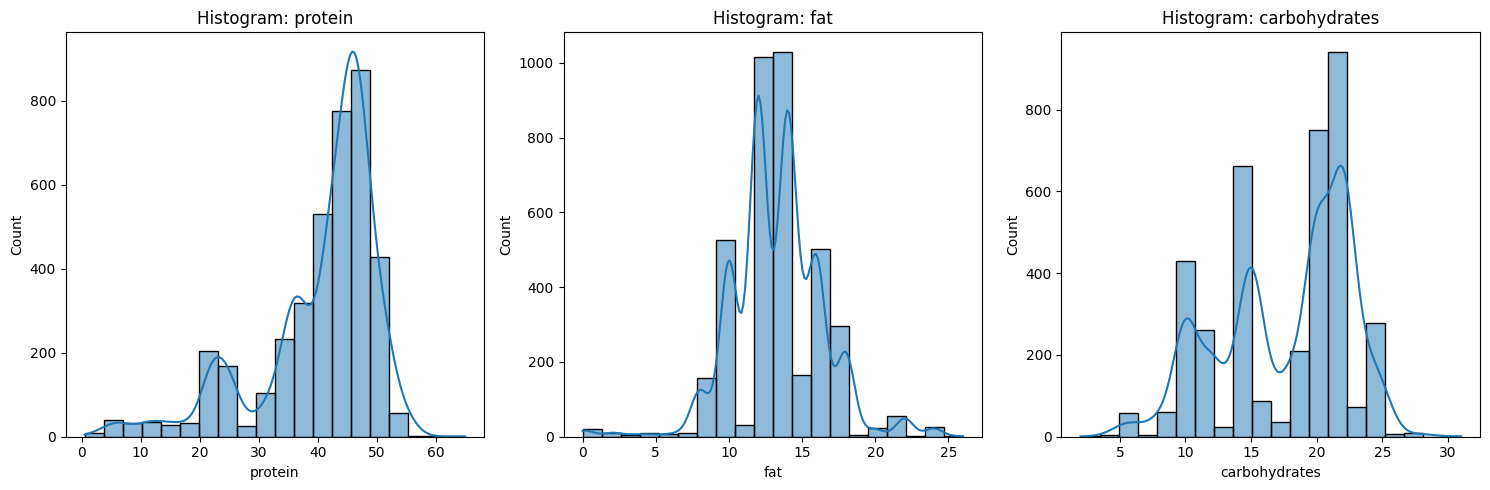

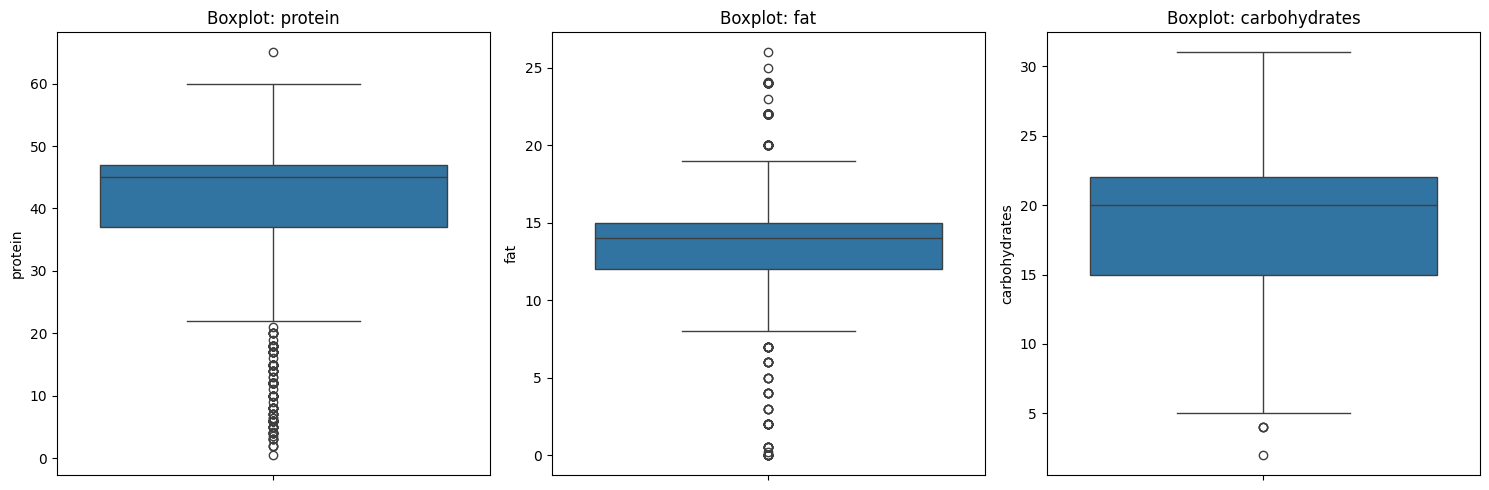

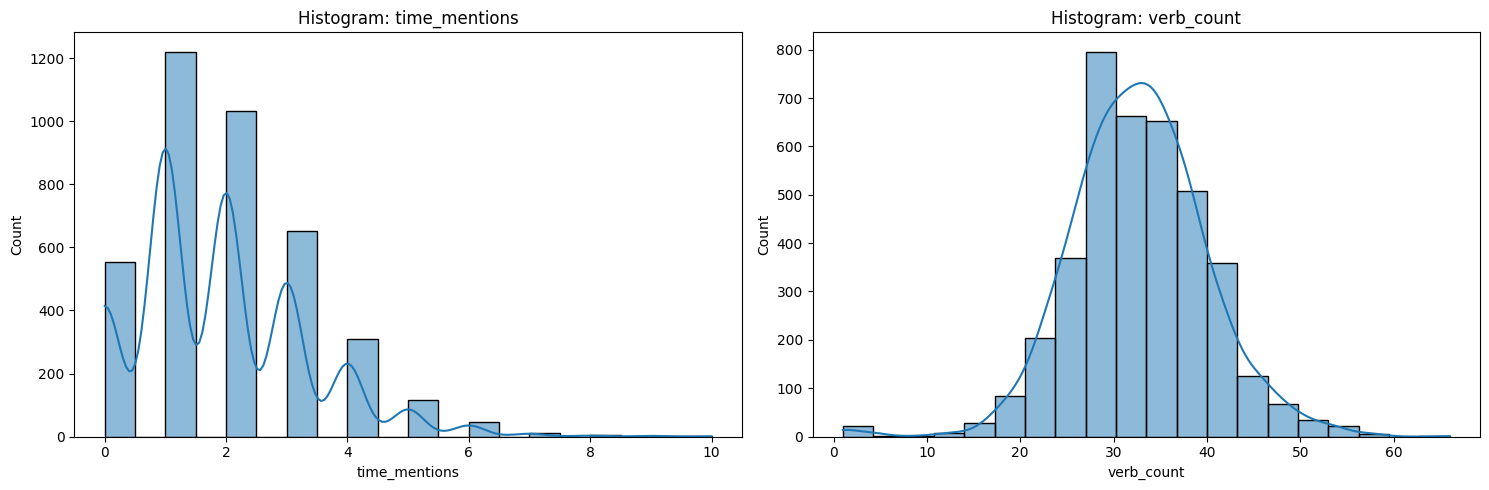

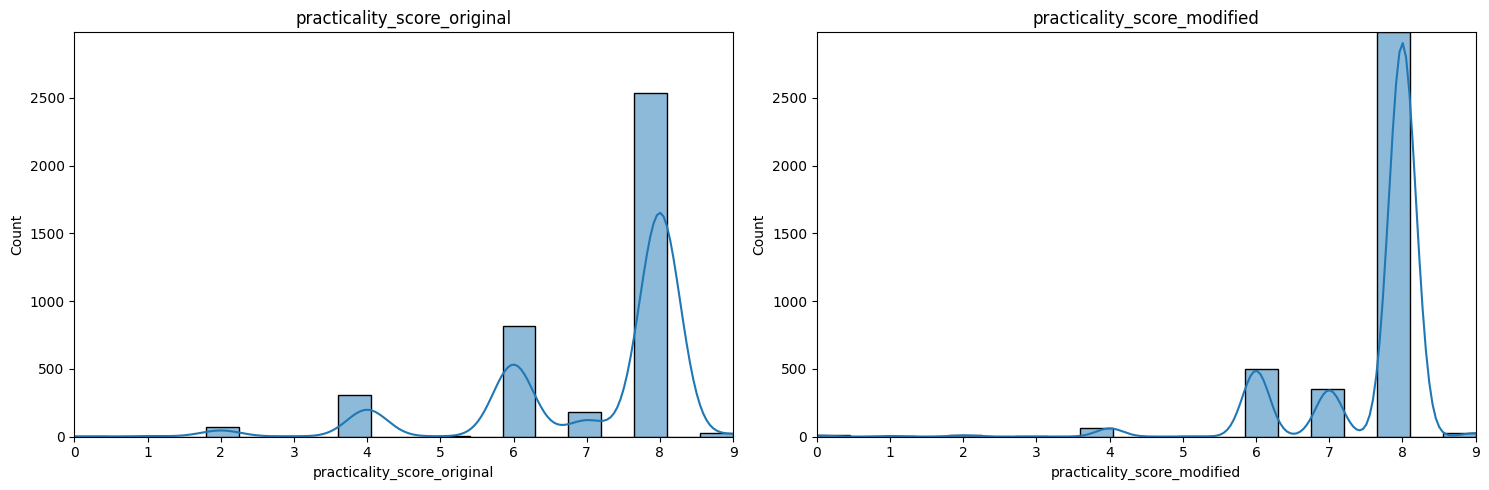

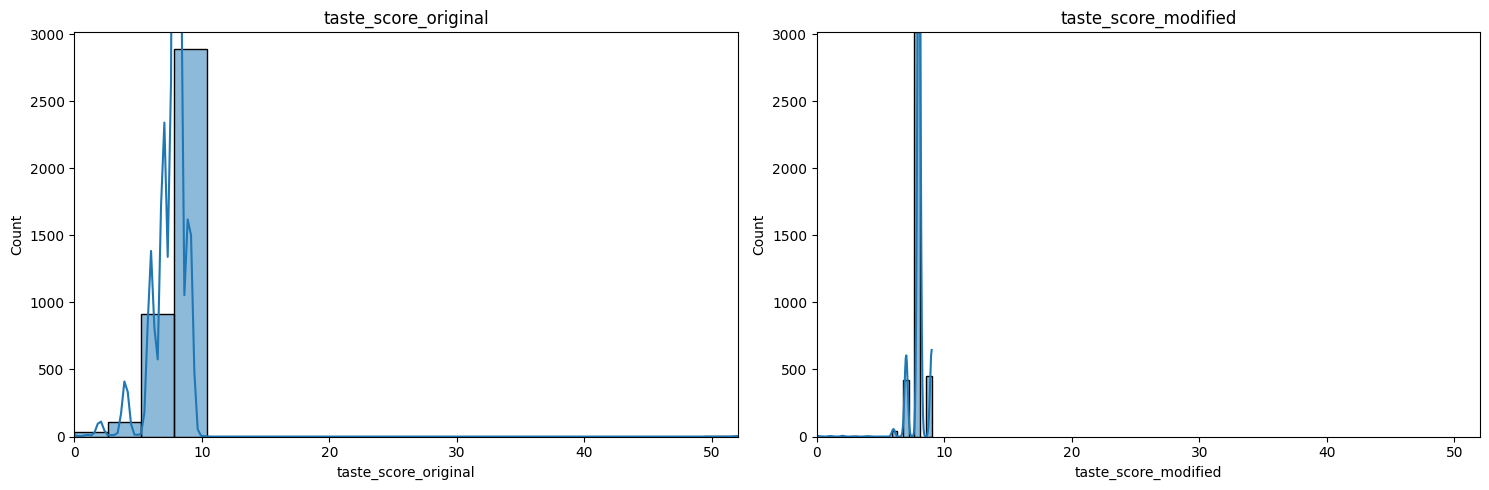

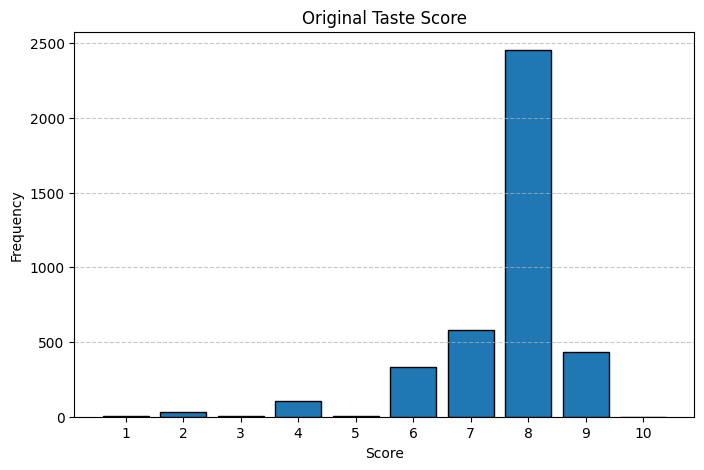

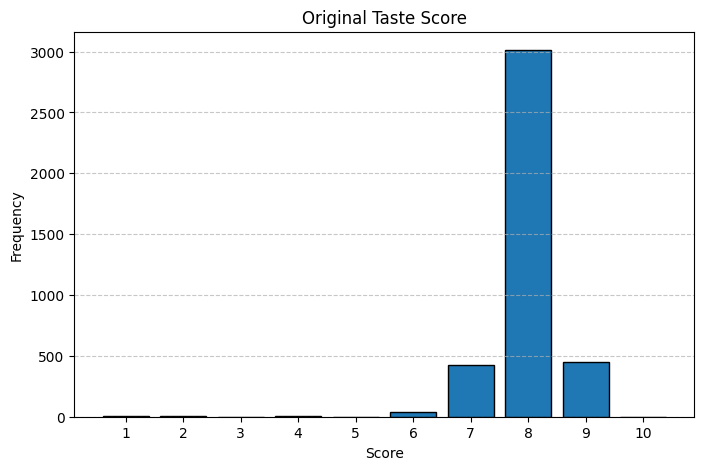

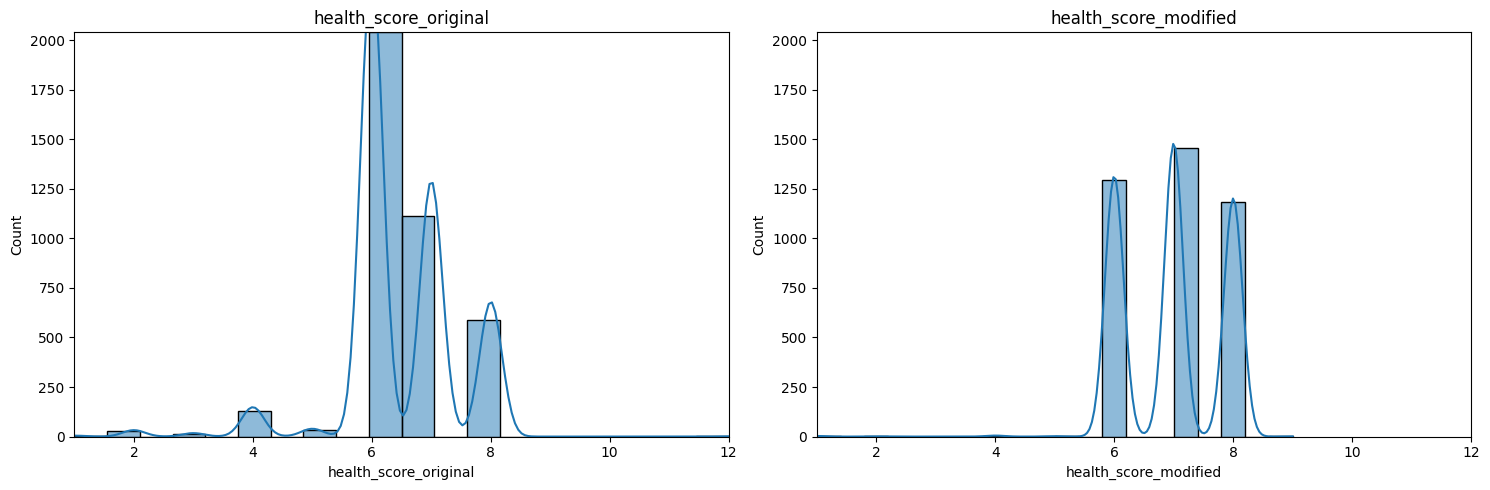

In [39]:
# macronutrient histograms and box plots
plot_metrics(results_df, ["protein", "fat", "carbohydrates"], kind='hist')
plot_metrics(results_df, ["protein", "fat", "carbohydrates"], kind='box')

# practicality histograms
plot_metrics(results_df, ["time_mentions", "verb_count"], kind='hist')
plot_global_metrics(results_df, ["practicality_score_original", "practicality_score_modified"], kind='hist')
plot_score_histogram(results_df["practicality_score_original"], title="Original Practicality Score")
plot_score_histogram(results_df["practicality_score_modified"], title="Modified Pra Score")

# taste histograms
plot_global_metrics(results_df, ["taste_score_original", "taste_score_modified"], kind='hist')
plot_score_histogram(results_df["taste_score_original"], title="Original Taste Score")
plot_score_histogram(results_df["taste_score_modified"], title="Modified Taste Score")

# healthiness histograms 
plot_global_metrics(results_df, ["health_score_original", "health_score_modified"], kind='hist')
plot_score_histogram(results_df["health_score_original"], title="Original Health Score")
plot_score_histogram(results_df["health_score_modified"], title="Modified Health Score")

In [28]:
def plot_categorical_column(df, column_name, title=None, figsize=(5, 5), rotation=45):
    """
    Plots a bar chart for a categorical column in a Pandas DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): Name of the categorical column to plot.
        title (str, optional): Title for the chart. Defaults to column name.
        figsize (tuple): Figure size. Default is (8, 5).
        rotation (int): Rotation angle for x-axis labels. Default is 45.
    """
    counts = df[column_name].value_counts(dropna=False)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=counts.index.astype(str), y=counts.values)
    plt.title(title or f"Distribution of '{column_name}'", fontsize=14)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()


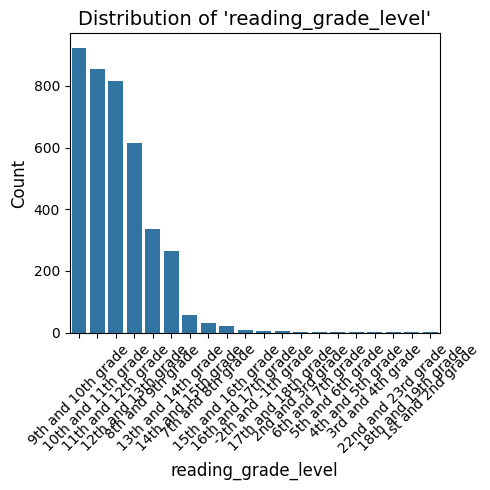

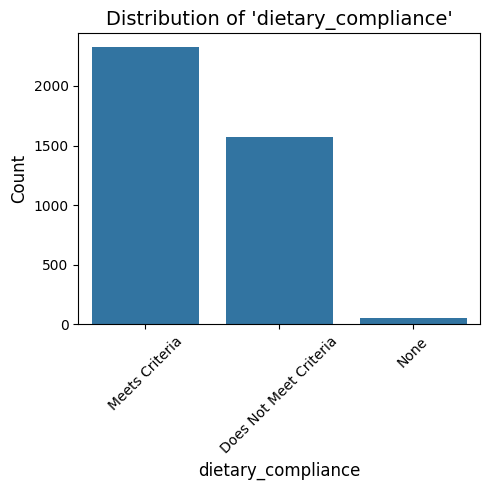

In [29]:
plot_categorical_column(results_df, "reading_grade_level")
plot_categorical_column(results_df, "dietary_compliance")

In [30]:
# save final results file because this took over 70 hours to run
results_df.to_csv("results_data.csv", index=False, encoding="utf-8")